# Splitting time-in-bed

We start by importing the data and then view a sample just to make sure it's all there. Our weapon of choice is numpy. The data consists of four columns: Subject ID, actigraph hours, self-report hours, and a difference score. Our variables of interest are the actigraph hours and self-report hours. Both these variables measure the time asleep in hours among 196 individuals, as measured by actigraph and a self-report questionnaire (PSQI) respectively. 

In [2]:
import numpy as np
np.set_printoptions(precision=2, suppress=True) # display 2 d.p.
data = np.genfromtxt('TiB.csv', delimiter=',', skip_header=1)
print("We have {} rows in the full data set.".format(data.shape[0]))
data = data[~np.isnan(data).any(axis=1)]
print("Checking for missing data. \
\nThere are {} rows in the checked data set".format(data.shape[0]))
#data[60:80,:].view()  # view a sample of records (lines 60 to 80)

We have 175 rows in the full data set.
Checking for missing data. 
There are 175 rows in the checked data set


#### Viewing the data  
Differences exist between our two variables of interest. To view these differences in more detail, we can use the magic of Seaborn (thanks Sam!).

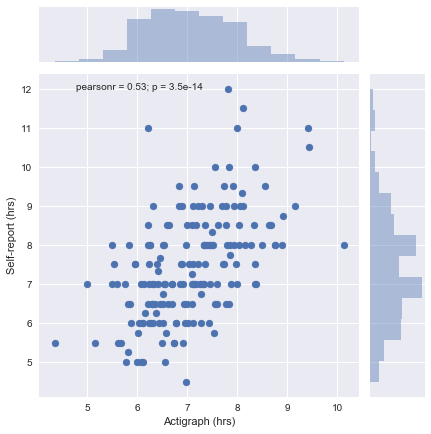

In [3]:
from scipy import stats, integrate
import matplotlib.pyplot as pl
import seaborn as ss
%matplotlib inline

x = data[:,1] # Actigraph hrs
y = data[:,2] # Self-report hrs

ss.set(color_codes=True)
ss.jointplot(x, y).set_axis_labels("Actigraph (hrs)", "Self-report (hrs)")
#ss.jointplot(x, y, kind="kde");

A simple scatterplot shows us the variables moderately covary (i.e., **r = 0.53**). Finding a perfect tertiary split might be possible given the amount of common variance in the datasets. 

#### Finding the best split
Our aim is to divide the data into tripartite divisions which result in three equivalent (but not equal) proportions in both data sets. In other words, the number of people in the lowest division of each dataset will be equal, and the number of people in the middle division of each dataset will be equal, and so on. 

Hence, we can define a cost function which represents the difference in proportions between datasets as 'error' or 'cost. Our aim is to minimize the 'cost' between data sets by carefully selecting our division thresholds.

The **split_costm** function includes an option to set a penalty (**Lambda**) as paramater values (our thresholds) get wider. Wider parameter values will result in smaller numbers in the top and bottom division, and larger numbers in the middle division as more people are captured by the parameters. Thus higher penalties (Lambda) will increase the number in the top and bottom division.

Our default dataset (**d**) will be the z-score transformed variables rather than raw hours. This means the threshold (**params**) will be given in z-score units rather than hours (e.g., -1 and +1 z-score units)

In [4]:
# Add a z-score transform to the data
x_z = stats.zscore(x) # Actigraph z-scores
y_z = stats.zscore(y) # Self-report z-scores
d = np.asarray([x_z,y_z]).T # create an array
d.shape

(175, 2)

In [39]:
# define a helper function
def crosstab(params, array=d):
    
    lb, ub = params
    short = array < lb
    med = (array > lb) & (array < ub)
    long = array > ub
    
    m = np.zeros([3,3])
    m[0,] = np.array([sum(short.all(axis=1)), 
                    sum(np.array([short[:,0], med[:,1]]).all(axis=0)), 
                    sum(np.array([short[:,0], long[:,1]]).all(axis=0))])
    
    m[1,] = np.array([sum(np.array([med[:,0], short[:,1]]).all(axis=0)), 
                    sum(med.all(axis=1)), 
                    sum(np.array([med[:,0], long[:,1]]).all(axis=0))])
    
    m[2,] = np.array([sum(np.array([long[:,0], short[:,1]]).all(axis=0)), 
                    sum(np.array([long[:,0], med[:,1]]).all(axis=0)), 
                    sum(long.all(axis=1))])
    return m

# Define the objective function with costs
def split_costm(params, array = d, Lambda = 0.5):
    
    # Cross tabulate the number of people defined as short, medium or long
    # in each variable then express that as a proportion (density)
    m = crosstab(params, array)   
    m = m / m.sum()
    
    # The diagonal elements in the crosstab will be people defined as short,
    # medium or long in both variables, which is good! Therefore, the 
    # numbers in the off-diagonal elements will be people misclassified
    # (i.e., classified as short in one variable and medium in the other).
    # These numbers can be considered errors, which we want to minimise.
    # Calculate cost of offdiagonal elements:
    offcost = m[~np.eye(3,dtype=bool)]
    offcost = offcost**2
    
    # As just explained, the people in the diagonal elements have been
    # classified the same way according to both variables. However, we
    # also want more people classified in the medium, or normal, group 
    # than the short or long groups. Therefore, the diagonal elements
    # must be compared to ensure the medium group is largest.
    # Calculate cost of diagonal elements
    m_diag = m[np.eye(3, dtype=bool)] 
    diagcost = np.mean(m_diag[m_diag != m_diag[1]]) - m_diag[1]
    
    # Finally, we want to ensure that parameters which place everyone in
    # the medium group are not chosen. i.e., we want to penalize parameters
    # which are too wide or large.
    # Regularization of parameter values
    regcost = np.asarray(params)**2
    
    # Sum the three sources of cost
    costsum = offcost.sum() + diagcost + Lambda*regcost.sum()
    
    return costsum

params = [-1, 1]
split_costm(params)

0.62635102040816326

Our cost function tells us the total difference (in arbitrary units) between the two datasets with the given parameters (-1 and +1).

At this point it is worth taking a look at the cost function. Given the small size of the parameter space and the low dimensional dataset (2D), we can easily visualize the cost function in 3 dimensions. What we are hoping to see is a smooth, convex function.

Mapping parameter space... Done


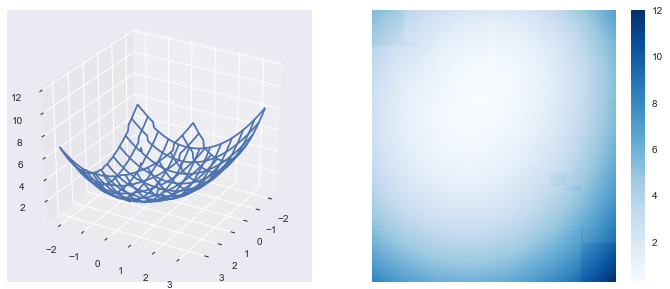

In [40]:
from mpl_toolkits.mplot3d import axes3d

lower_bound = max(x_z.min(),y_z.min()) # lower boundary of our param space
upper_bound = min(x_z.max(),y_z.max()) # upper boundary of our param space

# Initialising x- and y-dimensions of our param space
xx = np.linspace(lower_bound,upper_bound,num=120)
yy = np.linspace(lower_bound,upper_bound,num=120)
Z = np.empty([len(xx),len(yy)])
                    
# finding the cost over our param space (i.e., z-dimension)
print('Mapping parameter space...',end='')
for row,i in enumerate(xx):
    for col,j in enumerate(yy):
        Z[row,col] = split_costm(params=[i,j]) # cost over param space

print(' Done')

# Plotting x, y and z
%matplotlib inline
X = np.tile(xx,(120,1))
Y = np.tile(yy,(120,1))
Y = Y.T

fig = pl.figure(figsize=(12,5))
ax = fig.add_subplot(121, projection='3d')
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
ax.view_init(30,30)

ax = fig.add_subplot(122)
ax = ss.heatmap(Z, cmap="Blues", xticklabels=False, yticklabels=False)
pl.show()

The 3D left plot shows the parameter space in x, y and z dimensions. Cost is height (z-dimension). The right plot shows a 2D top-down view of the 3D plot - peaks are blue (highest cost > 2.0), valleys are white (lowest cost < 0.40). The plots show a smooth convex function, with the default regularization parameter. 

In [41]:
from scipy.optimize import optimize
result = np.asarray([0,0])
result = result.reshape(1,2)
xdim = np.linspace(-1.28, 1.28, num=20)
ydim = np.linspace(-1.28, 1.28, num=20)
best = 1
print('Searching parameter space...', end='')
for i in xdim:
    for j in ydim:
        local_min = optimize.fmin(split_costm, x0=([i,j]), disp=0)
        if split_costm(local_min) < best and (local_min[0] < local_min[1]):
            result = np.append(result,local_min.reshape(1,2), axis = 0)
            best = split_costm(local_min)
print(' Done')

print(result)

Searching parameter space... Done
[[ 0.    0.  ]
 [-0.82  0.43]
 [-0.35  0.23]
 [-0.7   0.43]
 [-0.39  0.47]
 [-0.39  0.43]
 [-0.39  0.43]
 [-0.32  0.43]
 [-0.32  0.43]
 [-0.32  0.43]
 [-0.32  0.43]]


In [56]:
# Check the best solution:
lb, ub = result[len(result)-8,]
print('Cost of', lb,'and', ub, 'is', split_costm([lb, ub]),'\n')

# Convert to hours
print('Converting these z-scores back to hours, we have:')
hours = {'Act_low': round(lb*np.std(x) + np.mean(x),2)}
hours['PSQI_low'] = round(lb*np.std(y) + np.mean(y),2)
hours['Act_high'] = round(ub*np.std(x) + np.mean(x),2)
hours['PSQI_high'] = round(ub*np.std(y) + np.mean(y),2)
print('Thresholds for actigraph are', hours['Act_low'], 'and', hours['Act_high'],'hours')
print('Thresholds for PSQI are', hours['PSQI_low'], 'and', hours['PSQI_high'],'hours')

table = crosstab([lb,ub])
row = ['short','medium','long']
print('\n')
print('Frequency table (Lambda = %.2f):\n' % (0.5))
print('%-10s%-10s%-10s%-10s' %(' ','short','medium','long'))
for i in range(3):
    print('%-10s%-10i%-10i%-10i' % (row[i],table[i,0], table[i,1], table[i,2]))

Cost of -0.701348082315 and 0.430605525228 is 0.275095941789 

Converting these z-scores back to hours, we have:
Thresholds for actigraph are 6.4 and 7.45 hours
Thresholds for PSQI are 6.48 and 8.03 hours


Frequency table (Lambda = 0.50):

          short     medium    long      
short     19        25        3         
medium    16        44        14        
long      1         27        26        


### Conclusion
With the above regularization parameter (Lambda), we found a local minima which meets the restrictions. Minor work is needed to optimize Lambda. For example, **increasing Lambda should increase the number of cases in the short-short and long-long cells**.

Frequency table (Lambda = 0.15):

          short     medium    long      
short     8         13        0         
medium    10        114       11        
long      0         15        4     